In [1]:
%matplotlib inline

from collections import Counter
from datetime import datetime, timedelta
from dotenv import find_dotenv, get_key
import json
import re

import numpy as np
import pandas as pd
from pylab import mpl, plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import alpaca_trade_api as tradeapi
alpaca_api_key = 'PKKSFLVI3BMIRQBN6C2K'
alpaca_secret_key = 'sW1fFZmq9HZwyL5p6OkFrJbr2TFq1H5IJ2njVLik'
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

from newsapi import NewsApiClient
#from newsapi.newsapi_client import NewsApiClient
api_key = '87dec3a300674a8a87b91a1da6ab30be'
newsapi = NewsApiClient(api_key=api_key)

import nltk
from nltk.corpus import inaugural, reuters, stopwords
#stopwords.words('english')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud

from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
tone_api = '0R866-tePJfMWni9gl454-jWDOS44kvX12Te4KZFe6Wr'
tone_url = 'https://api.us-east.tone-analyzer.watson.cloud.ibm.com/instances/fc8d2c71-5116-43ab-8c9a-de4a584aa663'

import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

---

NLP Natural Language Processing<br>
&nbsp;&nbsp;&nbsp;&nbsp;
Preprocessing<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Tokenization<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Lemmatization<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Stopwording<br>
&nbsp;&nbsp;&nbsp;&nbsp;
Extraction<br>
&nbsp;&nbsp;&nbsp;&nbsp;
Analysis<br>
&nbsp;&nbsp;&nbsp;&nbsp;
Representation<br>

Frequency Analysis<br>
Counting tokens<br>
Ngram<br>
Word Cloud<br>

Text Modeling<br>
Sentiment Analysis<br>
Tone Analysis<br>

https://docs.python.org/3/library/re.html<br>
https://spacy.io/api/data-formats<br>
https://spacy.io/api/data-formats#pos-tagging<br>

---

In [2]:
reuters.categories()

['acq',
 'alum',
 'barley',
 'bop',
 'carcass',
 'castor-oil',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee',
 'copper',
 'copra-cake',
 'corn',
 'cotton',
 'cotton-oil',
 'cpi',
 'cpu',
 'crude',
 'dfl',
 'dlr',
 'dmk',
 'earn',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut-oil',
 'heat',
 'hog',
 'housing',
 'income',
 'instal-debt',
 'interest',
 'ipi',
 'iron-steel',
 'jet',
 'jobs',
 'l-cattle',
 'lead',
 'lei',
 'lin-oil',
 'livestock',
 'lumber',
 'meal-feed',
 'money-fx',
 'money-supply',
 'naphtha',
 'nat-gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm-oil',
 'palmkernel',
 'pet-chem',
 'platinum',
 'potato',
 'propane',
 'rand',
 'rape-oil',
 'rapeseed',
 'reserves',
 'retail',
 'rice',
 'rubber',
 'rye',
 'ship',
 'silver',
 'sorghum',
 'soy-meal',
 'soy-oil',
 'soybean',
 'strategic-metal',
 'sugar',
 'sun-meal',
 'sun-oil',
 'sunseed',
 'tea',
 'tin',
 'trade',
 'veg-oil',
 'wheat',
 'wpi',
 'yen',
 'zinc']

---

In [134]:
def process_text (article):
    sw = set(stopwords.words('english'))
    sw_addons = {'said', 'sent', 'found', 'including', 'today', 'announced', 'week', 'basically', 'also'}
    regex = re.compile('[^a-zA-Z ]')
    re_clean = regex.sub('', article)
    words = word_tokenize(re_clean)
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw.union(sw_addons)]
    return output
def process_text_bg (doc):
    sw_words = process_text(doc)
    bigrams = ngrams(sw_words, 2)
    output = ['_'.join(i) for i in bigrams]
    return output
def word_counter (corpus):
    ''' Combine all articles in corpus into one large string. '''
    big_string = ' '.join(corpus)
    processed = process_text(big_string)
    top_10 = dict(Counter(processed).most_common(10))
    return pd.DataFrame(list(top_10.items()), columns=['word', 'count'])
def bigram_counter (corpus):
    ''' Combine all articles in corpus into one large string. '''
    big_string = ' '.join(corpus)
    processed = process_text(big_string)
    bigrams = ngrams(processed, n=2)
    top_10 = dict(Counter(bigrams).most_common(10))
    return pd.DataFrame(list(top_10.items()), columns=['bigram', 'count'])

In [128]:
ids = reuters.fileids(categories='gas')
corpus = [reuters.raw(i) for i in ids]
display(
    word_counter(corpus),
    bigram_counter(corpus),
)

sentence_tokenized = [sent_tokenize(i) for i in corpus]

word_tokenized = []
for story in sentence_tokenized:
    words = []
    for sent in story:
        words = words + word_tokenize(sent)
    word_tokenized.append(words)

reuters_cpi = pd.DataFrame({'articles': corpus,
                            'sentence_tokenized': sentence_tokenized,
                            'word_tokenized': word_tokenized})
reuters_cpi.index = ids
reuters_cpi.head()

,word,count
0,mln,214
1,pct,135
2,gasoline,113
3,oil,101
4,crude,72
5,year,70
6,barrel,70
7,price,68
8,bpd,56
9,would,48


,bigram,count
0,"(mln, barrel)",53
1,"(mln, bpd)",47
2,"(pct, mln)",33
3,"(bpd, pct)",29
4,"(crude, oil)",22
5,"(mln, eia)",20
6,"(year, ago)",20
7,"(rose, pct)",19
8,"(crude, mln)",18
9,"(says, distillate)",17


,articles,sentence_tokenized,word_tokenized
test/14863,FINNS AND CANADIANS TO STUDY MTBE PRODUCTION P...,[FINNS AND CANADIANS TO STUDY MTBE PRODUCTION ...,"[FINNS, AND, CANADIANS, TO, STUDY, MTBE, PRODU..."
test/15339,"EIA SAYS DISTILLATE STOCKS UNCHANGED, GASOLINE...","[EIA SAYS DISTILLATE STOCKS UNCHANGED, GASOLIN...","[EIA, SAYS, DISTILLATE, STOCKS, UNCHANGED, ,, ..."
test/15344,EIA SAYS DISTILLATE STOCKS UNCHANGED IN WEEK\n...,[EIA SAYS DISTILLATE STOCKS UNCHANGED IN WEEK\...,"[EIA, SAYS, DISTILLATE, STOCKS, UNCHANGED, IN,..."
test/15351,RECENT U.S. OIL DEMAND OFF 2.6 PCT FROM YEAR A...,[RECENT U.S. OIL DEMAND OFF 2.6 PCT FROM YEAR ...,"[RECENT, U.S., OIL, DEMAND, OFF, 2.6, PCT, FRO..."
test/16581,EXXON &lt;XON> EXTENDS MID-GRADE UNLEADED MARK...,[EXXON &lt;XON> EXTENDS MID-GRADE UNLEADED MAR...,"[EXXON, &, lt, ;, XON, >, EXTENDS, MID-GRADE, ..."


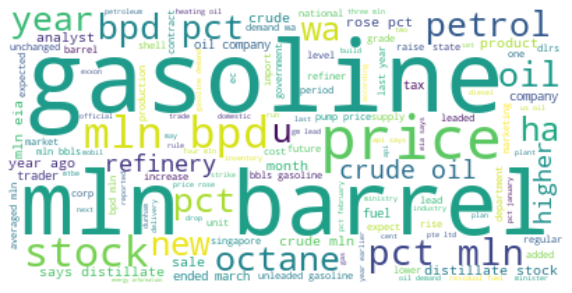

In [129]:
wc = WordCloud(background_color='white').generate(' '.join(process_text(' '.join(corpus))))
plt.figure(figsize=(10, 8));
plt.imshow(wc, interpolation='bilinear');
plt.axis('off');
plt.title('');

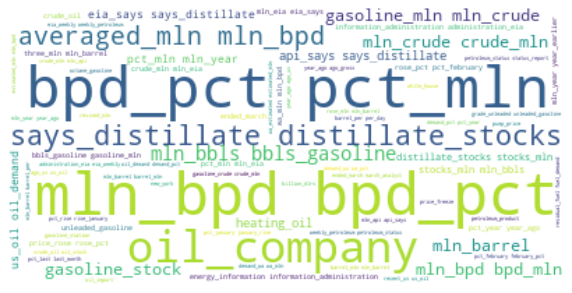

In [136]:
plt.figure(figsize=(10, 8));
wc = WordCloud(background_color='white').generate(' '.join(process_text_bg(' '.join(corpus))))
plt.imshow(wc, interpolation='bilinear');
plt.axis('off');
plt.title('');

---

In [3]:
authenticator = IAMAuthenticator(tone_api)
tone_analyzer = ToneAnalyzerV3(
    version='2017-09-21',
    authenticator=authenticator,
)
tone_analyzer.set_service_url(tone_url)

text = """
Team, I know that times are tough!
Product sales have been disappointing for the past three quarters.
We have a competitive product, but we need to do a better job of selling it!
"""

tone_analysis = tone_analyzer.tone(
    {'text': text},
    content_type='application/json',
    content_language='en',
    accept_language='en',
).get_result()
print(json.dumps(tone_analysis, indent=2))

doc_tone_df = pd.json_normalize(data=tone_analysis['document_tone'], record_path=['tones'])
doc_tone_df

sentences_tone_df = pd.json_normalize(
    data=tone_analysis['sentences_tone'],
    record_path=['tones'],
    meta=['sentence_id', 'text'],
)
sentences_tone_df

utterances = [
    {"text": "Hello, I'm having a problem with your product.", "user": "customer"},
    {"text": "OK, let me know what's going on, please.", "user": "agent"},
    {"text": "Well, nothing is working :(", "user": "customer"},
    {"text": "Sorry to hear that.", "user": "agent"},
]
utterance_analysis = tone_analyzer.tone_chat(
    utterances=utterances, content_language='en', accept_language='en',
).get_result()
print(json.dumps(utterance_analysis, indent=2))

chat_tone_df = pd.json_normalize(
    data=utterance_analysis['utterances_tone'],
    record_path=['tones'],
    meta=['utterance_id', 'utterance_text'],
)
chat_tone_df

{
  "document_tone": {
    "tones": [
      {
        "score": 0.6165,
        "tone_id": "sadness",
        "tone_name": "Sadness"
      },
      {
        "score": 0.829888,
        "tone_id": "analytical",
        "tone_name": "Analytical"
      }
    ]
  },
  "sentences_tone": [
    {
      "sentence_id": 0,
      "text": "Team, I know that times are tough!",
      "tones": [
        {
          "score": 0.801827,
          "tone_id": "analytical",
          "tone_name": "Analytical"
        }
      ]
    },
    {
      "sentence_id": 1,
      "text": "Product sales have been disappointing for the past three quarters.",
      "tones": [
        {
          "score": 0.771241,
          "tone_id": "sadness",
          "tone_name": "Sadness"
        },
        {
          "score": 0.687768,
          "tone_id": "analytical",
          "tone_name": "Analytical"
        }
      ]
    },
    {
      "sentence_id": 2,
      "text": "We have a competitive product, but we need to do a bette

,score,tone_id,tone_name,utterance_id,utterance_text
0,0.686361,polite,Polite,0,"Hello, I'm having a problem with your product."
1,0.927240,polite,Polite,1,"OK, let me know what's going on, please."
2,0.997795,sad,Sad,2,"Well, nothing is working :("
3,0.730982,polite,Polite,3,Sorry to hear that.
4,0.672499,sympathetic,Sympathetic,3,Sorry to hear that.


---

In [4]:
def retrieve_docs (terms):
    result_docs = []
    for doc_id in money_news_ids:
        found_terms = [
            word
            for word in reuters.words(doc_id)
            if any(term in word.lower() for term in terms)
        ]
        if len(found_terms) > 0:
            result_docs.append(doc_id)
    return result_docs

def create_df (news, language):
    """
    Transforms the articles into a DataFrame.
    
    Parameters
    ==========
    news [list]: the list of articles
    language [string]: specifies the language of the articles
    """
    articles = []
    for article in news:
        try:
            title = article['title']
            description = article['description']
            text = article['content']
            date = article['publishedAt'][:10]
            articles.append({
                'title': title,
                'description': description,
                'text': text,
                'date': date,
                'language': language,
            })
        except AttributeError:
            pass
    return pd.DataFrame(articles)

crisis_news_en = newsapi.get_everything(q='financial crisis 2008', language='en')
crisis_news_en['totalResults']

crisis_news_fr = newsapi.get_everything(q='financière crise 2008', language='fr')
crisis_news_fr['totalResults']

crisis_en_df = create_df(crisis_news_en['articles'], 'en')
crisis_fr_df = create_df(crisis_news_fr['articles'], 'fr')
crisis_df = pd.concat([crisis_en_df, crisis_fr_df])
crisis_df.tail()

crisis_df.to_csv('./crisis_news_en_fr.csv', index=False, encoding='utf-8-sig')

---

In [4]:
analyzer = SentimentIntensityAnalyzer()
libra_headlines = newsapi.get_everything(
    q='facebook libra',
    language='en',
    page_size=100,
    sort_by='relevancy',
)
libra_sentiments = []
for article in libra_headlines['articles']:
    try:
        text = article['content']
        date = article['publishedAt'][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment['compound']
        pos = sentiment['pos']
        neu = sentiment['neu']
        neg = sentiment['neg']
        libra_sentiments.append({
            'text': text,
            'date': date,
            'compound': compound,
            'positive': pos,
            'negative': neg,
            'neutral': neu,
        })
    except AttributeError:
        pass
libra_df = pd.DataFrame(libra_sentiments)
cols = ['date', 'text', 'compound', 'positive', 'negative', 'neutral']
libra_df = libra_df[cols]
libra_df.head()

---

In [4]:
categories = ['money-fx', 'money-supply']
all_docs_id = reuters.fileids()
money_news_ids = [
    doc
    for doc in all_docs_id
    if categories[0] in reuters.categories(doc)
    or categories[1] in reuters.categories(doc)
]
money_news = [reuters.raw(doc).lower() for doc in money_news_ids]

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(money_news)
money_news_df = pd.DataFrame(
    list(zip(vectorizer.get_feature_names(), np.ravel(X.sum(axis=0)))),
    columns=['Word', 'Frequency'],
)
money_news_df = money_news_df.sort_values(by=['Frequency'], ascending=False)
money_news_df.head()

top_words = money_news_df[(money_news_df['Frequency'] >= 10) & (money_news_df['Frequency'] <= 30)]
top_words.head()

terms_list = str(top_words['Word'].tolist())
wordcloud = WordCloud(colormap='RdYlBu', background_color='white').generate(terms_list)
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis('off');
plt.title('Money News Word Cloud', fontdict={'fontsize': 20, 'fontweight': 'bold'});

len(retrieve_docs(['yen']))
len(retrieve_docs(['japan', 'banks']))
len(retrieve_docs(['england', 'dealers']))

---

In [4]:
doc_ids = reuters.fileids()
len(doc_ids)

doc_id = 'test/15045'
doc_text = reuters.raw(doc_id)
doc_text

vectorizer = CountVectorizer(stop_words='english')
vectorizer

X = vectorizer.fit_transform([doc_text])
print(X)

words = vectorizer.get_feature_names()
words

words_df = pd.DataFrame(list(zip(words, np.ravel(X.sum(axis=0)))), columns=['Word', 'Word_Count'])
words_df



all_docs_id = reuters.fileids()
corpus_id = all_docs_id[:1000]
corpus = [reuters.raw(doc) for doc in corpus_id]
vectorizer = TfidfVectorizer(stop_words='english')
X_corpus = vectorizer.fit_transform(corpus)
words_corpus = vectorizer.get_feature_names()
words_corpus_df = pd.DataFrame(list(zip(words_corpus, np.ravel(X_corpus.mean(axis=0)))), columns=['Word', 'TF-IDF'])
words_corpus_df = words_corpus_df.sort_values(by=['TF-IDF'], ascending=False)
words_corpus_df

---

In [57]:
def get_headlines (keyword):
    all_headlines = []
    all_dates = []
    date = datetime.strptime(current_date[:10], '%Y-%m-%d')
    end_date = datetime.strptime(past_date[:10], '%Y-%m-%d')
    print(f'Fetching news about \'{keyword}\'')
    print('*' * 30)
    while date > end_date:
        print(f'retrieving news from: {date}')
        articles = newsapi.get_everything(
            q=keyword,
            from_param=str(date)[:10],
            to=str(date)[:10],
            language='en',
            sort_by='relevancy',
            page=1,
        )
        headlines = []
        for i in range(0, len(articles['articles'])):
            headlines.append(articles['articles'][i]['title'])
        all_headlines.append(headlines)
        all_dates.append(date)
        date = date - timedelta(days=1)
    return all_headlines, all_dates

def headline_sentiment_summarizer_avg (headlines):
    sentiment = []
    for day in headlines:
        day_score = []
        for h in day:
            if h == None:
                continue
            else:
                day_score.append(sid.polarity_scores(h)['compound'])
        sentiment.append(sum(day_score) / len(day_score))
    return sentiment

---

In [51]:
ticker = 'AAPL'
timeframe = '1D'
current_date = pd.Timestamp(datetime.now(), tz='America/New_York').isoformat()
past_date = pd.Timestamp(datetime.now() - timedelta(30), tz='America/New_York').isoformat()
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=past_date,
    end=current_date,
    after=None,
    until=None,
).df
df.head()

AAPL                                      
                             open      high     low     close    volume
time                                                                   
2021-03-31 00:00:00-04:00  121.65  123.5200  121.15  122.1800  94475011
2021-04-01 00:00:00-04:00  123.65  124.1800  122.49  123.0000  65403569
2021-04-05 00:00:00-04:00  123.87  126.1601  123.07  125.9001  79312943
2021-04-06 00:00:00-04:00  126.50  127.1300  125.65  126.2300  70316590
2021-04-07 00:00:00-04:00  125.83  127.9200  125.14  127.9100  75433362

In [52]:
df = df.droplevel(axis=1, level=0)
df = df.drop(columns=['open', 'high', 'low', 'volume'])
df.index = df.index.date
df.head()

,close
2021-03-31,122.1800
2021-04-01,123.0000
2021-04-05,125.9001
2021-04-06,126.2300
2021-04-07,127.9100


In [53]:
aapl_returns = df.pct_change().dropna()
aapl_returns.head()

,close
2021-04-01,0.006711
2021-04-05,0.023578
2021-04-06,0.002620
2021-04-07,0.013309
2021-04-08,0.019232


In [55]:
aapl_headlines, dates = get_headlines('apple')
trade_headlines, _ = get_headlines('trade')
economy_headlines, _ = get_headlines('economy')

Fetching news about 'apple'
******************************
retrieving news from: 2021-04-30 00:00:00
retrieving news from: 2021-04-29 00:00:00
retrieving news from: 2021-04-28 00:00:00
retrieving news from: 2021-04-27 00:00:00
retrieving news from: 2021-04-26 00:00:00
retrieving news from: 2021-04-25 00:00:00
retrieving news from: 2021-04-24 00:00:00
retrieving news from: 2021-04-23 00:00:00
retrieving news from: 2021-04-22 00:00:00
retrieving news from: 2021-04-21 00:00:00
retrieving news from: 2021-04-20 00:00:00
retrieving news from: 2021-04-19 00:00:00
retrieving news from: 2021-04-18 00:00:00
retrieving news from: 2021-04-17 00:00:00
retrieving news from: 2021-04-16 00:00:00
retrieving news from: 2021-04-15 00:00:00
retrieving news from: 2021-04-14 00:00:00
retrieving news from: 2021-04-13 00:00:00
retrieving news from: 2021-04-12 00:00:00
retrieving news from: 2021-04-11 00:00:00
retrieving news from: 2021-04-10 00:00:00
retrieving news from: 2021-04-09 00:00:00
retrieving news f

In [58]:
sid = SentimentIntensityAnalyzer()

aapl_avg = headline_sentiment_summarizer_avg(aapl_headlines)
trade_avg = headline_sentiment_summarizer_avg(trade_headlines)
economy_avg = headline_sentiment_summarizer_avg(economy_headlines)

topic_sentiments = pd.DataFrame({'aapl_avg': aapl_avg, 'trade_avg': trade_avg, 'economy_avg': economy_avg})
topic_sentiments.index = pd.to_datetime(dates)
topic_sentiments = aapl_returns.join(topic_sentiments).dropna(how='any')
topic_sentiments

,close,aapl_avg,trade_avg,economy_avg
2021-04-01,0.006711,0.031140,0.012465,0.151895
2021-04-05,0.023578,0.066610,0.171115,0.094840
2021-04-06,0.002620,0.262250,0.083030,0.109210
2021-04-07,0.013309,-0.002540,0.012705,0.130105
2021-04-08,0.019232,0.000585,-0.068855,0.114510
2021-04-09,0.020173,-0.025520,-0.052630,-0.013170
2021-04-12,-0.013083,0.028335,0.052780,0.131135
2021-04-13,0.023998,0.058765,0.057265,0.033165
2021-04-14,-0.017037,-0.050860,0.019220,0.133885
2021-04-15,0.018014,0.133615,-0.119125,0.082985


In [59]:
topic_sentiments.corr().style.background_gradient()

,close,aapl_avg,trade_avg,economy_avg
close,1.000000,0.044293,-0.161919,0.054640
aapl_avg,0.044293,1.000000,-0.014097,-0.044969
trade_avg,-0.161919,-0.014097,1.000000,-0.093465
economy_avg,0.054640,-0.044969,-0.093465,1.000000


---

In [45]:
article = reuters.raw(fileids = reuters.fileids(categories='gas')[0])
doc = nlp(article)
displacy.render(doc, style='ent')

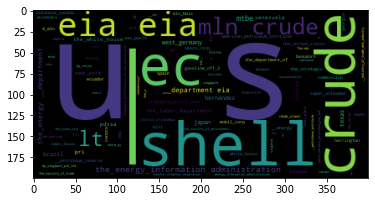

In [46]:
articles = reuters.raw(categories='gas')
doc = nlp(articles)
entities = [ent.text for ent in doc.ents if ent.label_ in ['GPE', 'ORG']]
entities = [i.lower().replace(' ', '_') for i in entities]
wc = WordCloud().generate(' '.join(entities))
plt.imshow(wc);

---

In [39]:
doc = nlp(u'Michael Jordan was a player in the National Basketball Association.')
for ent in doc.ents:
    print('{:40}{:40}'.format(ent.text, ent.label_))

Michael Jordan                          PERSON                                  
the National Basketball Association     ORG                                     


In [43]:
article = reuters.raw(fileids = reuters.fileids(categories='yen')[1])
doc = nlp(article)
print([ent.text for ent in doc.ents if ent.label_ == 'GPE'])
displacy.render(doc, style='ent')

['JAPAN', 'Japan', 'Washington', 'Japan', 'Paris', 'Britain', 'Canada', 'France', 'Italy', 'Japan', 'U.S.', 'West Germany']


---

In [33]:
def most_freq_adj (text):
    """ This function uses spaCy to get the most common adjectives from each text.
    
    Parameters
    ==========
      text (string): The text to analyze
    
    Returns
    =======
      most_common_adj (list): A list containing a tuple with the most common adjective and its occurrence in the text
    """
    
    # Tokenizes text and parses each token
    doc = nlp(text)
    
    # Creates a list with all the adjectives in the text
    adjs = [token.text.lower() for token in doc if token.pos_ == 'ADJ']
    
    # Retrieves the most frequent adjective in the `adjs` list using the Counter module
    most_common_adj = Counter(adjs).most_common(1)
    
    return most_common_adj

def all_adj (text):
    """ This function retrieves all the adjectives on the given text.
    
    Parameters
    ==========
      text (string): The text to analyze.
      
    Returns
    =======
      adjs (string): A list with all the adjectives in the text
    """
    
    # Tokenize the text and parse each token
    doc = nlp(text)
    
    # Create a list with all the adjectives in the text
    adjs = [token.text.lower() for token in doc if token.pos_ == 'ADJ']
    
    return adjs

def get_word_counts (text, word):
    """ This function counts the occurrences of a word in a text.
    
    Parameters
    ==========
      text (string): The text where word counts will be analyzed
      word (string): The word to look into the text
      
    Returns
    =======
      word_count (int): The counts of the word in the given text
    """
    
    # Use the word_tokenize module from NLTK to tokenize the text
    tok = word_tokenize(text)
    
    # Create a list with all the tokens retrieved from the text
    tok = [word.lower() for word in tok]
    
    # Count the occurrences of the word in the text
    word_count = tok.count(word)
    
    return word_count

def describe_america (text):
    """ This function retrieves the adjectives in the text that describe the word 'America'.
    Parameters
      text (string): The text to analyze.
    Returns
      adjs (list): A list of the adjectives that describe the word 'America' in the text.
    """
    
    # Use the spaCy English language model to tokenize the text and parse each token
    doc = nlp(text)
    
    # Create a list with all the adjectives in the text that describe the word 'America'
    adjs = [token.text.lower() for token in doc if (token.pos_ == 'ADJ' and token.head.text == 'America')]
    
    return adjs

In [25]:
ids = inaugural.fileids()
texts = [inaugural.raw(id) for id in ids]
adjs = [most_freq_adj(text) for text in texts]
df_adjs = pd.DataFrame({'doc_id': ids, 'adjective': adjs})
df_adjs.head()

,doc_id,adjective
0,1789-Washington.txt,"[(public, 6)]"
1,1793-Washington.txt,"[(fellow, 1)]"
2,1797-Adams.txt,"[(foreign, 8)]"
3,1801-Jefferson.txt,"[(own, 6)]"
4,1805-Jefferson.txt,"[(public, 14)]"


In [32]:
all_adjectives = []
for text in texts:
    all_adjectives = all_adjectives + all_adj(text)
most_freq_adjectives = Counter(all_adjectives).most_common(3)
great_counts = [get_word_counts(text, 'great') for text in texts]
other_counts = [get_word_counts(text, 'other') for text in texts]
own_counts = [get_word_counts(text, 'own') for text in texts]
dates = [id.split('-')[0] for id in ids]
presidents = [id.split('-')[1].split('.')[0] for id in ids]
adjectives_data = {'president': presidents, 'great': great_counts, 'other': other_counts, 'own': own_counts}
df_adjectives = pd.DataFrame(adjectives_data, index=pd.to_datetime(dates).year)
df_adjectives.head()

,president,great,other,own
1789,Washington,3,1,2
1793,Washington,0,0,0
1797,Adams,5,2,4
1801,Jefferson,1,1,6
1805,Jefferson,1,6,5


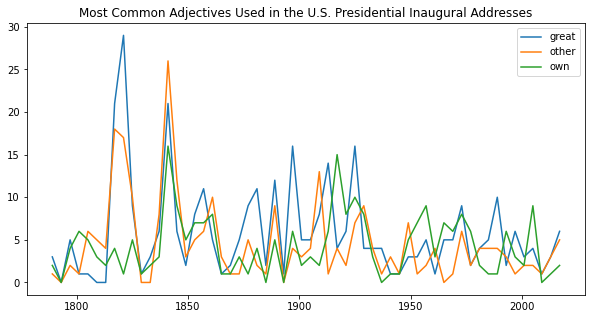

In [34]:
df_adjectives.plot(
    title='Most Common Adjectives Used in the U.S. Presidential Inaugural Addresses',
    figsize=(10, 5),
);

In [35]:
america_adjectives = []
for text in texts:
    america_adjectives = america_adjectives + describe_america(text)
america_adjectives

['united', 'productive', 'alert', 'strong', 'stronger', 'rich']

---

In [16]:
def parser (s):
    tokens = nlp(s)
    l = []
    for token in tokens:
        l.append('{:20}{:20}{:20}{:20}'.format(token.text, token.pos_, token.dep_, token.head.text))
    return l

In [18]:
s1 = 'The brown cow jumped over the round moon.'
s2 = 'Jose made a book collector happy the other day.'
res = parser(s2)
for line in res:
    print(line)

Jose                PROPN               nsubj               made                
made                VERB                ROOT                made                
a                   DET                 det                 collector           
book                NOUN                compound            collector           
collector           NOUN                nsubj               happy               
happy               ADJ                 ccomp               made                
the                 DET                 det                 day                 
other               ADJ                 amod                day                 
day                 NOUN                npadvmod            happy               
.                   PUNCT               punct               made                


In [10]:
nouns = [token.text for token in tokens if token.pos_ == 'NOUN']
cow_describers = [token.text for token in tokens if (token.head.text == 'cow' and token.pos_ == 'ADJ')]
display(
    nouns,
    cow_describers,
)

['cow', 'moon']

['brown']

In [7]:
displacy.render(tokens, style='dep')

---